<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Logistic_/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install watermark

In [2]:
%load_ext watermark
%watermark -a 'Ishan Dahal' -v -p torch

Ishan Dahal 

CPython 3.6.9
IPython 5.5.0

torch 1.7.0+cu101


### **Logistic Regression**

Implementing classic logistic regression for binary class labels

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

**Preparing toy dataset**

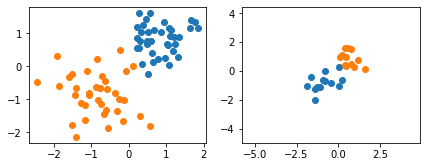

In [4]:
data = np.genfromtxt('https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss20/master/L07-logistic/code/data/toydata.txt', delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)

X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1])
ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1])
ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1])
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

## Low-level implementation with manual gradients

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LogisticRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(1, self.num_features, 
                                   dtype=torch.float, device=device)            #shape 1X2
        self.bias = torch.zeros(1, dtype=torch.float, device=device)            #shape 1

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights.t()), self.bias).view(-1)   #shape nX1
        probas = self._sigmoid(linear)
        return probas

    def backward(self, x, y, probas):

        grad_loss_out = probas.view(-1) - y                                     #shape nX1
        grad_loss_w = torch.mm(grad_loss_out.view(-1, 1).t(), x)                #shape 1X2
        grad_loss_b = torch.sum(grad_loss_out)                                  #shape 1
        return (-1) * grad_loss_w, (-1) * grad_loss_b                           #negative grads

    def predict_labels(self, x):
        probas = self.forward(x)
        labels = torch.where(probas > 0.5, torch.tensor([1]).to("cuda"), torch.tensor([0]).to('cuda'))
        return labels

    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy

    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba.view(-1, 1)))           #shape 1
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))      #shape 1

        return tmp1 - tmp2

    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):

            ## compute the outputs
            probas = self.forward(x)

            # compute the gradients
            grad_w, grad_b = self.backward(x, y, probas)

            # Update weights
            self.weights += learning_rate * grad_w
            self.bias += learning_rate * grad_b

            ## Logging 
            cost = self._logit_cost(y, self.forward(x)) / y.size(0)
            print(f'Epoch: {e+1:03d}', end="")
            print(f'  | Train Acc: {self.evaluate(x, y):.3f}', end="")
            print(f"  | Cost: {cost.item():.3f}")
            epoch_cost.append(cost)
            
        return epoch_cost


In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)

model1 = LogisticRegression1(X_train_tensor.size(1))
epoch_cost = model1.train(X_train_tensor, y_train_tensor, num_epochs=30,
                          learning_rate=0.1)
print('\nModel Parameters:')
print(f"    Weights: {model1.weights}")
print(f"    Bias: {model1.bias}")

Epoch: 001  | Train Acc: 0.973  | Cost: 0.055
Epoch: 002  | Train Acc: 0.973  | Cost: 0.053
Epoch: 003  | Train Acc: 0.973  | Cost: 0.051
Epoch: 004  | Train Acc: 0.973  | Cost: 0.049
Epoch: 005  | Train Acc: 0.973  | Cost: 0.048
Epoch: 006  | Train Acc: 0.973  | Cost: 0.047
Epoch: 007  | Train Acc: 0.973  | Cost: 0.046
Epoch: 008  | Train Acc: 0.973  | Cost: 0.045
Epoch: 009  | Train Acc: 0.973  | Cost: 0.044
Epoch: 010  | Train Acc: 0.987  | Cost: 0.043
Epoch: 011  | Train Acc: 0.987  | Cost: 0.042
Epoch: 012  | Train Acc: 0.987  | Cost: 0.041
Epoch: 013  | Train Acc: 0.987  | Cost: 0.041
Epoch: 014  | Train Acc: 0.987  | Cost: 0.040
Epoch: 015  | Train Acc: 0.987  | Cost: 0.039
Epoch: 016  | Train Acc: 0.987  | Cost: 0.039
Epoch: 017  | Train Acc: 1.000  | Cost: 0.038
Epoch: 018  | Train Acc: 1.000  | Cost: 0.038
Epoch: 019  | Train Acc: 1.000  | Cost: 0.037
Epoch: 020  | Train Acc: 1.000  | Cost: 0.036
Epoch: 021  | Train Acc: 1.000  | Cost: 0.036
Epoch: 022  | Train Acc: 1.000  | 

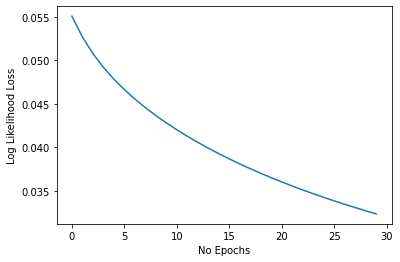

In [7]:
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel('No Epochs')
plt.ylabel("Log Likelihood Loss")
plt.show()

In [8]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

test_acc = model1.evaluate(X_test_tensor, y_test_tensor)
print(f'Test set accuracy: {test_acc*100:.2f}%')

Test set accuracy: 96.00%


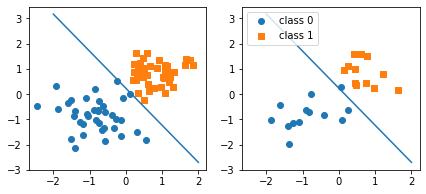

In [9]:


##########################
### 2D Decision Boundary
##########################

w, b = model1.weights.view(-1), model1.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()



### High-level Implementation using nn.Module API

In [23]:
class LogisticRegression2(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1).cuda()
        # initialize weights to zeros here,
        # since we used zero weights 
        # in manual mode
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # trailing underscore is for inplace operation in PyTorch

    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

model2 = LogisticRegression2(num_features=X_test_tensor.size(1))
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [25]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = torch.where((pred_probas > 0.5), 
                              torch.tensor([1]).cuda(), 
                              torch.tensor([0]).cuda()).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc

num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device).view(-1, 1)

for e in range(num_epochs):

    # compute outputs 
    out = model2(X_train_tensor)

    # compute gradients
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    cost.backward()

    ## update weights
    optimizer.step()

    ## logging 
    pred_probas = model2(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print(f"Epoch: {e+1:03d}", end="")
    print(f"    | Train Acc: {acc:.3f}", end='')
    print(f"    | Cost: {F.binary_cross_entropy(pred_probas, y_train_tensor):.3f}")

print("\n Weight parameters:")
print(f'   Weights: {model2.linear.weight}')
print(f"    Bias: {model2.linear.bias}")

Epoch: 001    | Train Acc: 0.973    | Cost: 0.055
Epoch: 002    | Train Acc: 0.973    | Cost: 0.053
Epoch: 003    | Train Acc: 0.973    | Cost: 0.051
Epoch: 004    | Train Acc: 0.973    | Cost: 0.049
Epoch: 005    | Train Acc: 0.973    | Cost: 0.048
Epoch: 006    | Train Acc: 0.973    | Cost: 0.047
Epoch: 007    | Train Acc: 0.973    | Cost: 0.046
Epoch: 008    | Train Acc: 0.973    | Cost: 0.045
Epoch: 009    | Train Acc: 0.973    | Cost: 0.044
Epoch: 010    | Train Acc: 0.987    | Cost: 0.043
Epoch: 011    | Train Acc: 0.987    | Cost: 0.042
Epoch: 012    | Train Acc: 0.987    | Cost: 0.041
Epoch: 013    | Train Acc: 0.987    | Cost: 0.041
Epoch: 014    | Train Acc: 0.987    | Cost: 0.040
Epoch: 015    | Train Acc: 0.987    | Cost: 0.039
Epoch: 016    | Train Acc: 0.987    | Cost: 0.039
Epoch: 017    | Train Acc: 1.000    | Cost: 0.038
Epoch: 018    | Train Acc: 1.000    | Cost: 0.038
Epoch: 019    | Train Acc: 1.000    | Cost: 0.037
Epoch: 020    | Train Acc: 1.000    | Cost: 0.036


Evaluating the model

In [26]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

pred_probas = model2(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print(f"Test set acc: {test_acc*100:.2f}%")

Test set acc: 96.00%


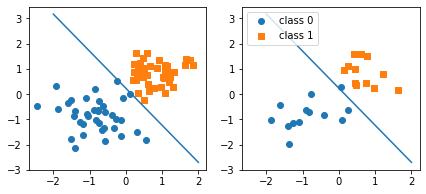

In [27]:
##########################
### 2D Decision Boundary
##########################

w, b = model2.linear.weight.view(-1), model2.linear.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

